# General equilibrium

#### Load packages

In [25]:
using Parameters
using Setfield
using Interpolations
using Plots
using Roots

#### Set up structures

In [26]:
@with_kw struct ModelParameters{T} # Economic Variables
    β :: T = 0.95
    γ :: T = 2.0
    ϵ :: T = 4.06
    χ :: T = 1.0
    ρ :: T = 0.9136 # Flodén and Lindé (2001)
    σ2 :: T = 0.0426 # Flodén and Lindé (2001)
end 

@with_kw struct NumericalParameters # Numerical Variables
    na   :: Int = 200 # asset grid
    na_c :: Int = 100
    amin :: Float64 = 0.0 
    amax :: Float64 = 50.0 
    ny   :: Int = 5 # income grid
    tol_pol :: Float64 = 1e-7
    max_iter :: Int = 500
end

# Load it already here, as it is needed below
n_par= NumericalParameters()

@with_kw struct ContainerHA{T} # T= Array{Float64,1}
    A  :: T  = zeros(n_par.na, n_par.ny) # policy function assets
    C  :: T  = zeros(n_par.na, n_par.ny) # policy function consumption
    N  :: T  = zeros(n_par.na, n_par.ny) # policy function hours worked
end

@with_kw struct Grids
    gridA :: Array{Float64,1} = zeros(n_par.na)         # asset grid
    Π :: Array{Float64,2} = zeros(n_par.ny, n_par.ny)   # transition matrix income
    gridθ :: Array{Float64,1} = zeros(n_par.ny)         # productivity grid
end

Grids

#### Discretization

In [27]:
function Rouwenhorst_AR1(ρ, σ2, N)

    p= (1+ρ)/2
    q= (1+ρ)/2
    
    # Construct Markov Chain recursively
    if N ==2
        tm= [p 1-p; 1-q q]
    elseif N>2
        tm= [p 1-p; 1-q q]
        for i in 2:N-1
            tm= p .* hcat( vcat(tm, zeros(1,i)), zeros(i+1,1) ) + 
            (1-p) .* hcat( zeros(i+1,1), vcat(tm, zeros(1,i)) ) +
            (1-q) .* hcat( vcat(zeros(1,i), tm), zeros(i+1,1) ) +
                q .* hcat( zeros(i+1,1), vcat(zeros(1,i), tm) )
            
            tm[2:end-1,:]= tm[2:end-1,:]./2 # divide all but the first and last row by two
        end
    else
        println("The number of grid points needs to be larger than two")
    end
    
    # Create state vector - here M is basically sqrt(iN-1)
    ψ= sqrt((σ2 / (1 - ρ^2))) * sqrt(N - 1)
    state= LinRange(-ψ, ψ, N)

    return state, tm

end # end Rouwenhorst_AR1 function

Rouwenhorst_AR1 (generic function with 1 method)

#### EGM (with endogenous labor)

In [28]:
function findMinimumConsumption(c, aprime, a, r, w, θ, γ, ϵ, χ)

    n= max.(0.0, 1.0 .- ( ( c.^(-γ) .* w .* θ) ./χ).^(-1/ϵ) ) # intra-temporal FOC

    rt= aprime + c - (1+r)*a - w*θ*n # budget

    return rt

end


function egm_step(m_par::ModelParameters, n_par::NumericalParameters, grids::Grids, Cprime, Cl, r, rprime, w)

    # Unpack
    @unpack_ModelParameters m_par
    @unpack_NumericalParameters n_par
    @unpack_Grids grids

    # Pre-allocation
    Ci= similar(Cprime, Float64)

    EUc= Cprime.^(-γ) * Π'  # RHS Euler (expectation)
    for y in 1:ny

        # unconstrained
        Cendog= ((1+rprime) .* β .* EUc[:,y]).^(-1/γ) # inter-temporal FOC (Euler)
        Nendog= max.(0.0, 1.0 .- ( ( Cendog.^(-γ) .* w .* gridθ[y]) ./χ).^(-1/ϵ) ) # intra-temporal FOC
        Aendog= (gridA .+ Cendog .- w.*Nendog.*gridθ[y]) ./ (1 + r) # budget constraint
        
        # constrained
        if Aendog[1] > amin            
            Cendog_c= collect(LinRange(Cl[y], Cendog[1], na_c)[1:na_c-1]) # get consumption on lower bound
            Nendog_c= max.(0.0, 1.0 .- ( ( Cendog_c.^(-γ) .* w .* gridθ[y]) ./χ).^(-1/ϵ) )
            Aendog_c= (amin .+ Cendog_c .- w.*Nendog_c.*gridθ[y]) ./ (1 + r)

            Cendog= append!(Cendog_c, Cendog)
            Aendog= append!(Aendog_c, Aendog)
        end

        itpC= LinearInterpolation(Aendog, Cendog, extrapolation_bc=Line())
        Ci[:,y]= itpC.(gridA)

    end

    return Ci

end

function egm(gV_conHA::ContainerHA, m_par::ModelParameters, n_par::NumericalParameters, grids::Grids, r, rprime, w)

    # Unpack
    @unpack_ContainerHA gV_conHA
    
    
    Ci= copy(C)
    difference= 1000.0
    it=1
    Cl= zeros(n_par.ny)


    # Find consumption at lower bound (constrained agents)
    for y in 1:n_par.ny
        Croot= (c -> findMinimumConsumption(c, n_par.amin, n_par.amin, r, w, grids.gridθ[y], m_par.γ, m_par.ϵ, m_par.χ)) # recover consumption if at lower bounds - Euler does not hold with equality - only use intra-temporal FOC and budget
        Cl[y]= find_zero(Croot, 1e-6 )
    end
    Cl[Cl.<=1e-6] .= 1e-6 # set min consumption


    while difference > n_par.tol_pol && it < n_par.max_iter
        Ci= egm_step(m_par::ModelParameters, n_par::NumericalParameters, grids::Grids, C, Cl, r, rprime, w)
        # Check and update
        difference= maximum(abs.(C .- Ci))
        C= copy(Ci)
        it= it+1
    end # end while


    # Fill policy functions
    for y in 1:n_par.ny
        N[:,y]= max.(0.0, 1.0 .- ( ( C[:,y].^(-m_par.γ) .* w .* grids.gridθ[y]) ./m_par.χ).^(-1/m_par.ϵ) )
        A[:,y]= w .* N[:,y] .* grids.gridθ[y] .+ (1+r).*grids.gridA .- C[:,y]
    end

    gV_conHA= ContainerHA(A=A, C=C, N=N) 

    # println("Finished EGM in iteration = ", it, ", and diff = ", difference)

    return gV_conHA

end

egm (generic function with 1 method)

#### Stationary Distribution 

In [29]:
function weights_and_indices(A,gridA,na,ny)

    A_indices= zeros(Int, na, ny) 
    wei= zeros(Float64,na,ny) 

    for y in 1:ny
        # Indices
        A_indices[:,y] = searchsortedlast.(Ref(gridA), A[:,y])  # gives left bracket; 0 if below grid, na if above grid
    end
    A_indices[A_indices .== 0] .= 1
    A_indices[A_indices .== na] .= na-1
    for y in 1:ny
        wei[:,y]= (A[:,y] .- [gridA[i] for i in A_indices[:,y]]) ./ ([gridA[i+1] for i in A_indices[:,y]] .- [gridA[i] for i in A_indices[:,y]])
    end
    # should never be binding, but just to be save
    wei[wei.>1] .=1
    wei[wei.<0] .=0

    return wei, A_indices

end


function loop!(A_disti::Array{Float64,2},A_indices::Array{Int,2},wei::Array{Float64,2},Π::Array{Float64,2},A_dist::Array{Float64,2},na::Int,ny::Int)

    @inbounds for i in 1:na
        for s in 1:ny
            index= A_indices[i,s]
            lottery1= (1-wei[i,s]) * A_dist[i,s]
            lottery2= wei[i,s]* A_dist[i,s]
            for si in 1:ny
                A_disti[index,si] += lottery1 * Π[s,si]
                A_disti[index + 1,si] += lottery2 * Π[s,si] 
            end
        end
    end

end

function density_discretization(gV_conHA::ContainerHA, grids::Grids, n_par::NumericalParameters,A_dist)

    # Unpack
    @unpack_NumericalParameters n_par
    @unpack_Grids grids
    
    # retrieve indices and weights for lottery
    wei, A_indices= weights_and_indices(gV_conHA.A, gridA, na, ny)

    difference= 100.0
    it=1
    # iterate over discretized density to get fixed point
    while difference > 1e-10 && it < 10000
    
        # always pre-allocate to zero
        A_disti= zeros(Float64,na,ny) 

        loop!(A_disti, A_indices, wei, Π, A_dist, na, ny)

        difference= maximum(abs.(A_disti .- A_dist))
        A_dist= A_disti ./ sum(A_disti)
        it= it+1

    end

    it == 10000 ? println("density_discretization did not converge") : Nothing

    return A_dist

end

density_discretization (generic function with 1 method)

#### Initialize

In [30]:
m_par= ModelParameters{Float64}()
gV_conHA= ContainerHA{Array{Float64,2}}();

lnproductivtyGrid, transitionMatrix= Rouwenhorst_AR1(m_par.ρ,m_par.σ2,n_par.ny);
productivityGrid= exp.(lnproductivtyGrid)

gridA= n_par.amin .+ (collect(0:n_par.na-1)./n_par.na).^2 .* (n_par.amax - n_par.amin);
grids= Grids(gridA=gridA, Π=transitionMatrix, gridθ=productivityGrid);

#### Household asset demand

To compute aggregate asset demand in the economy, we combine the steps from the other notebooks. First, solve for the household policy functions using the EGM and then discretize the invariant density. Use both to compute aggregate asset demand. We do this in the following function. 


In [31]:
function householdAssetDemand(gV_conHA, m_par, n_par, grids, r, rprime, w)

    # EGM
    gV_conHA= egm(gV_conHA, m_par, n_par, grids, r, rprime, w);

    # Stationary distribution
    # Start from uniform distribution
    mA_Dist= ones(n_par.na, n_par.ny) ./ (n_par.na * n_par.ny) 
    mA_Dist= density_discretization(gV_conHA, grids, n_par, mA_Dist)

    # Aggregates - Asset demand
    dA= sum(mA_Dist .* gV_conHA.A)

    return dA

end

householdAssetDemand (generic function with 1 method)

#### General equilibrium

We assume a fixed supply of assets. To find equilibrium, we have to find prices such that, given optimizing behavior of households, aggregate (asset) supply equals aggregate (asset) demand. In the following, we iterate over the interest rate to achieve equilibrium: Increase the interest rate if asset supply > asset demand and vice versa. One could also use a root-finding method to solve for the equilibrium interest rate, but I want to iterate for illustration. 

In [32]:
## Assume that production is linear in labor -> wage equals unity
# Wage
w= 1.0

# Interest rate
# r is now determined by market clearing
r = 0.03 # starting value

# Government bond supply - fixed
dB= 1.6

# Guess
Cguess= ones(n_par.na, n_par.ny) .* r .+ gridA;
gV_conHA= ContainerHA(C=Cguess);

### Iterate on interest rate for asset market clearing - one could also use a root-finder to solve for r, but this is for illustration
differenceMarketClearing= 100.0
iterationMarketClearing=1
while differenceMarketClearing > 1e-5 && iterationMarketClearing < 300

    dA = householdAssetDemand(gV_conHA, m_par, n_par, grids, r, r, w)
    differenceMarketClearing= abs(dA - dB)

    println("Market clearing = ", differenceMarketClearing, " in iteration ", iterationMarketClearing)

    # Update
    r= r - 0.01*(dA - dB) # if demand for assets is bigger than supply, decrease interest rate

    iterationMarketClearing= iterationMarketClearing+1

end

println("Equilibrium interest rate ", r)

Market clearing = 0.1762415443267118 in iteration 1
Market clearing = 0.00893853797215205 in iteration 2
Market clearing = 0.0010501219881300372 in iteration 3
Market clearing = 0.0001268520690820285 in iteration 4
Market clearing = 1.537247646887785e-5 in iteration 5
Market clearing = 1.8636236300828557e-6 in iteration 6
Equilibrium interest rate 0.028136257075438254


#### Plot market clearing

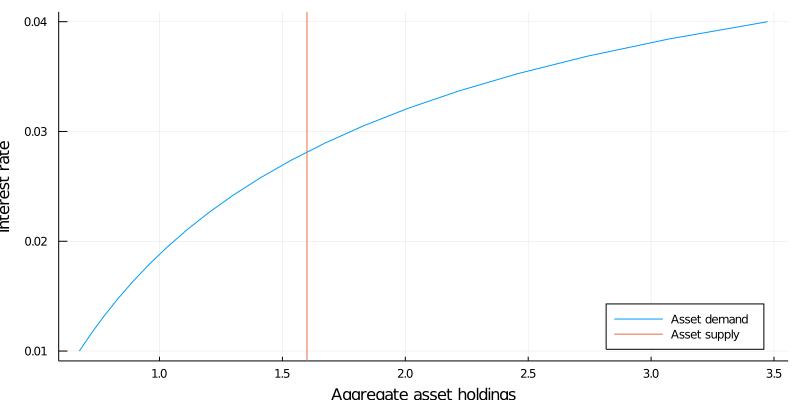

In [33]:
vInterestRates= LinRange(0.01, 0.04, 20)
vDemand= similar(vInterestRates)

for (i,dr) in enumerate(vInterestRates)
    vDemand[i]= householdAssetDemand(gV_conHA, m_par, n_par, grids, dr, dr, w)
end

plot(vDemand, vInterestRates, label="Asset demand", ylabel= "Interest rate", xlabel="Aggregate asset holdings", legend=:bottomright)
vline!([dB], label="Asset supply")
plot!(size=(800,400))


#### Example of calibration in general equilibrium: Get discount factor to get an interest rate of 3%.

To do so, we create a function which can be fed into a root-finding step. The idea here is to fix an interest rate (because this is an observable variable) and adjust the discount factor to get asset market clearing. Now, instead of iterating on the discount factor, I use a root-finding step. 

In [34]:
function marketClearing(gV_conHA, m_par, n_par, grids, dB)

    w= 1.0
    r= 0.03 # guess

    ### Iterate on asset market clearing - one could also use a root-finder to solve for r, but this is for illustration
    differenceMarketClearing= 100.0
    iterationMarketClearing=1
    while differenceMarketClearing > 1e-5 && iterationMarketClearing < 300

        dA = householdAssetDemand(gV_conHA, m_par, n_par, grids, r, r, w)
        differenceMarketClearing= abs(dA - dB)

        # Update
        r= r - 0.01*(dA - dB) # if demand for assets is bigger than supply, decrease interest rate

        iterationMarketClearing= iterationMarketClearing+1

    end

    return r

end

function calibrateB(gV_conHA, m_par, n_par, grids, dB)
    println("Guess for β = ", m_par.β)
    return 0.03 - marketClearing(gV_conHA, m_par, n_par, grids, dB)
end


calibrationHelper= (beta -> calibrateB(gV_conHA, setproperties(m_par,(β=beta)), n_par, grids, dB))
beta_cal= find_zero(calibrationHelper, 0.9, atol=1e-4)
@set! m_par.β= beta_cal


Guess for β = 0.900006055487454
Guess for β = 0.9
Guess for β = 0.944840761265992
Guess for β = 0.9006055487454027
Guess for β = 0.9448789088449447
Guess for β = 0.9448789088449447
Guess for β = 0.9480157161218922
Guess for β = 0.9480157161218922
Guess for β = 0.9482649607743707
Guess for β = 0.9482649607743707


ModelParameters{Float64}
  β: Float64 0.9482649607743707
  γ: Float64 2.0
  ϵ: Float64 4.06
  χ: Float64 1.0
  ρ: Float64 0.9136
  σ2: Float64 0.0426


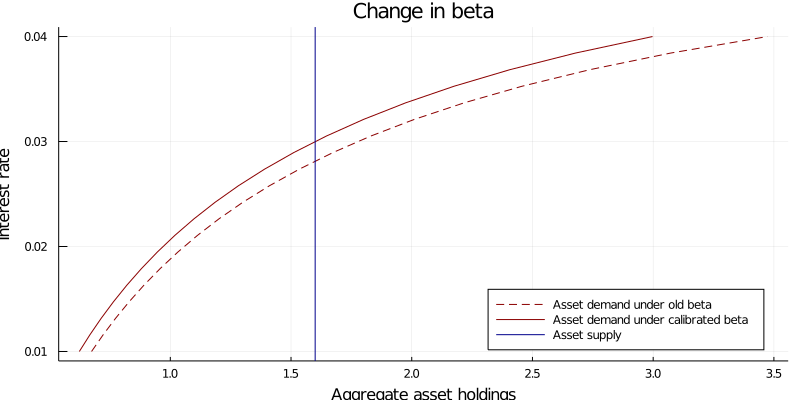

In [35]:
# Plot result with new beta
vDemand_cal= similar(vDemand) # asset demand with calibrated beta
for (i,dr) in enumerate(vInterestRates)
    vDemand_cal[i]= householdAssetDemand(gV_conHA, m_par, n_par, grids, dr, dr, w)
end

plot(vDemand, vInterestRates, label="Asset demand under old beta", ylabel= "Interest rate", xlabel="Aggregate asset holdings", legend=:bottomright, lc=:darkred, ls=:dash, title="Change in beta")
plot!(vDemand_cal, vInterestRates, label="Asset demand under calibrated beta", lc=:darkred, ls=:solid)
vline!([dB], label="Asset supply", lc=:darkblue)
plot!(size=(800,400))